In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define ResNet-like architecture
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



/home/dgreen/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define the model, loss function, and optimizer
net = ResNet(ResNetBlock, [7, 4, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

/home/dgreen/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [5]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)

Total trainable parameters: 4919114


In [6]:
from torchsummary import summary
summary(net.cuda(), (3,64,64), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 64, 64]           1,728
       BatchNorm2d-2            [1, 64, 64, 64]             128
            Conv2d-3            [1, 64, 64, 64]          36,864
       BatchNorm2d-4            [1, 64, 64, 64]             128
            Conv2d-5            [1, 64, 64, 64]          36,864
       BatchNorm2d-6            [1, 64, 64, 64]             128
       ResNetBlock-7            [1, 64, 64, 64]               0
            Conv2d-8            [1, 64, 64, 64]          36,864
       BatchNorm2d-9            [1, 64, 64, 64]             128
           Conv2d-10            [1, 64, 64, 64]          36,864
      BatchNorm2d-11            [1, 64, 64, 64]             128
      ResNetBlock-12            [1, 64, 64, 64]               0
           Conv2d-13            [1, 64, 64, 64]          36,864
      BatchNorm2d-14            [1, 64,

In [7]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# Training loop
for epoch in range(100):
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            test_loss += criterion(outputs, labels).item()

    test_loss /= len(testloader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch + 1}/100], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Update learning rate
    scheduler.step(test_loss)

print('Finished Training')

Epoch [1/100], Train Loss: 1.5251, Train Acc: 43.10%, Test Loss: 1.2828, Test Acc: 55.95%
Epoch [2/100], Train Loss: 1.0415, Train Acc: 62.62%, Test Loss: 0.9360, Test Acc: 66.63%
Epoch [3/100], Train Loss: 0.8341, Train Acc: 70.48%, Test Loss: 0.7873, Test Acc: 72.62%
Epoch [4/100], Train Loss: 0.6923, Train Acc: 75.79%, Test Loss: 0.6949, Test Acc: 77.01%
Epoch [5/100], Train Loss: 0.5885, Train Acc: 79.58%, Test Loss: 0.6686, Test Acc: 77.42%
Epoch [6/100], Train Loss: 0.5122, Train Acc: 82.33%, Test Loss: 0.6193, Test Acc: 79.17%
Epoch [7/100], Train Loss: 0.4568, Train Acc: 84.25%, Test Loss: 0.5758, Test Acc: 81.51%
Epoch [8/100], Train Loss: 0.3280, Train Acc: 88.88%, Test Loss: 0.3641, Test Acc: 87.84%
Epoch [9/100], Train Loss: 0.2944, Train Acc: 90.00%, Test Loss: 0.3636, Test Acc: 87.88%
Epoch [10/100], Train Loss: 0.2757, Train Acc: 90.57%, Test Loss: 0.3472, Test Acc: 88.58%
Epoch [11/100], Train Loss: 0.2623, Train Acc: 91.00%, Test Loss: 0.3551, Test Acc: 88.16%
Epoch [1

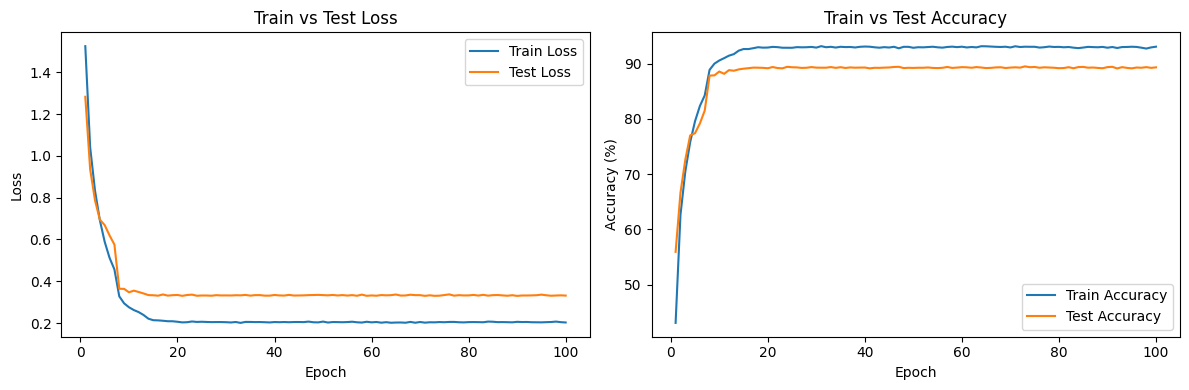

In [8]:
# Plotting
epochs = range(1, 101)

plt.figure(figsize=(12, 4))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Evaluate the model on test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 89.330000 %


In [10]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.data = []
        self.labels = []

        # Load all data batches
        for file_path in file_paths:
            with open(file_path, 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                self.data.append(batch[b'data'])
                # Labels or targets can be 'labels' or 'fine_labels', depending on the CIFAR-10 dataset variant
                # self.labels += batch[b'ids']

        # Convert data to a numpy array and reshape
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # Convert to HWC format for PIL
        
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        # label = self.labels[idx]

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image

In [11]:
custom_test=["/home/dgreen/sem2/dl/resnet/scratch_implementation/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl"]


In [12]:
test_dataset = CIFAR10Dataset(custom_test,transform=transform_test)


In [13]:
ans=[]
with torch.no_grad():
    correct = 0
    total = 0
    for data in test_dataset:
        net.eval()
        images = data
        images=images.reshape((1,images.shape[0],images.shape[1],images.shape[2]))
        images= images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        ans.append(predicted)

print(ans)

[tensor([8], device='cuda:0'), tensor([9], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([7], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([4], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([6], device='cuda:0'), tensor([9], device='cuda:0'), tensor([4], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([0], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8], device='cuda:0'), tensor([8

In [14]:
import pandas as pd
data_df = pd.DataFrame()

In [15]:
id =0 
lbl =[]
da = []
for i in ans:
    lbl.append(id)
    da.append(i.item())
    id = id + 1

In [16]:
data_df['ID'] = lbl
data_df['Labels'] = da

In [17]:
data_df.to_csv("pkb_743.csv", index=False)